# Vecchia Approximation and Nearest-Neighbors GPs

Vecchia's approximation breaks down the joint distribution into a product of conditional distributions, each conditioned on a subset of selected points. Nearest Neighbor Gaussian Processes (NNGP) are a specific implementation of Vecchia's method where each conditioning set consists of the m nearest neighbors from the preceding data points. The primary difference lies in the selection of conditioning sets, while Vecchia allows for flexible criteria, NNGP strictly uses preceeding nearest neighbors for causality.




In [21]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial.distance import cdist
from scipy.linalg import cholesky, solve_triangular
from sklearn.neighbors import NearestNeighbors
from scipy.stats import multivariate_normal

### Vecchia

In [22]:
# Seed for reproducibility
np.random.seed(42)

# Number of data points
n = 1000  # Adjust as needed; larger n will increase computation time

# Generate 1D spatial locations
X = np.linspace(0, 10, n).reshape(-1, 1)  # Shape: (n, 1)

# Define the true underlying latent function
true_function = (
    0.5 * np.sin(0.1 * X.flatten()) +         # Very low-frequency component
    np.sin(X.flatten()) +                     # Standard frequency
    0.3 * np.sin(10 * X.flatten()) +         # Higher-frequency component
    0.2 * np.sin(50 * X.flatten()) +         # Very high-frequency component
    0.1 * X.flatten()                         # Linear trend
)

# Generate noisy observations
noise_std = 0.2
Y = true_function + np.random.randn(n) * noise_std


In [23]:
# Maximum number of conditioning variables
m = 10  # Adjust based on computational resources and desired accuracy

# Fit NearestNeighbors on the data
# Note: For Vecchia, neighbors are selected among previous points to maintain ordering
nbrs = NearestNeighbors(n_neighbors=m, algorithm='auto').fit(X)

# Find the m nearest neighbors for each point
# To ensure causality, we'll consider only points with indices less than the current point
# Therefore, we need to find neighbors within the subset of previous points
conditioning_sets = []

for i in range(n):
    if i == 0:
        conditioning_sets.append([])
        continue
    # Query all points before the current index
    distances, indices = nbrs.kneighbors(X[i].reshape(1, -1), n_neighbors=m, return_distance=True)
    # Filter neighbors to include only previous points
    neighbors = indices[0][distances[0] < np.inf]
    neighbors = neighbors[neighbors < i]
    # If fewer than m neighbors are found, take as many as available
    neighbors = neighbors[-m:] if len(neighbors) >= m else neighbors
    conditioning_sets.append(neighbors.tolist())


In [24]:
def exponential_covariance(x1, x2, sigma2, rho):
    """
    Exponential (Matérn 1/2) covariance function.
    """
    pairwise_dists = cdist(x1, x2, metric='euclidean')
    return sigma2 * np.exp(-pairwise_dists / rho)

In [25]:
def compute_vecchia_loglik(Y, X, conditioning_sets, sigma2, rho, jitter=1e-6):
    """
    Compute the Vecchia approximate log-likelihood for Gaussian Processes.

    Parameters:
    - Y: Observed data (n,)
    - X: Input locations (n, d)
    - conditioning_sets: List of lists containing indices of conditioning points for each data point
    - sigma2: Variance parameter
    - rho: Range parameter
    - jitter: Small value to add to diagonal for numerical stability

    Returns:
    - log_likelihood: Scalar log-likelihood value
    """
    n = len(Y)
    log_likelihood = 0.0

    # Precompute the covariance matrix diagonal
    var_y = sigma2 + jitter

    for i in range(n):
        if i == 0 or len(conditioning_sets[i]) == 0:
            # Prior for the first point or points with no conditioning set
            mean_i = 0.0
            var_i = var_y
            log_likelihood += multivariate_normal.logpdf(Y[i], mean=mean_i, cov=var_i)
        else:
            Ci = conditioning_sets[i]
            X_Ci = X[Ci]
            Y_Ci = Y[Ci]

            # Compute covariance matrices
            K_CiCi = exponential_covariance(X_Ci, X_Ci, sigma2, rho) + np.eye(len(Ci)) * jitter
            K_iCi = exponential_covariance(X[i].reshape(1, -1), X_Ci, sigma2, rho)  # Shape: (1, |Ci|)

            # Cholesky decomposition for numerical stability
            try:
                L = cholesky(K_CiCi, lower=True)
            except np.linalg.LinAlgError:
                # Add more jitter if decomposition fails
                K_CiCi += np.eye(len(Ci)) * jitter
                L = cholesky(K_CiCi, lower=True)

            # Solve for alpha: K_CiCi * alpha = Y_Ci
            alpha = solve_triangular(L, Y_Ci, lower=True)
            alpha = solve_triangular(L.T, alpha, lower=False)

            # Conditional mean
            mean_i = K_iCi @ alpha

            # Compute the conditional variance
            # v = solve(L, K_iCi.T)
            v = solve_triangular(L, K_iCi.T, lower=True)
            var_i = sigma2 - v.T @ v

            # Ensure variance is positive
            var_i = np.maximum(var_i, jitter)

            # Update log-likelihood
            log_likelihood += multivariate_normal.logpdf(Y[i], mean=mean_i, cov=var_i)

    return log_likelihood


In [26]:
from scipy.optimize import minimize

def negative_vecchia_loglik(params, Y, X, conditioning_sets):
    """
    Negative Vecchia log-likelihood for optimization.

    Parameters:
    - params: Tuple containing (sigma2, rho)
    - Y: Observed data (n,)
    - X: Input locations (n, d)
    - conditioning_sets: Conditioning sets for Vecchia approximation

    Returns:
    - Negative log-likelihood
    """
    sigma2, rho = params
    # Ensure parameters are positive
    if sigma2 <= 0 or rho <= 0:
        return np.inf
    loglik = compute_vecchia_loglik(Y, X, conditioning_sets, sigma2, rho)
    return -loglik  # Negative for minimization

# Initial guesses for hyperparameters
initial_params = [1.0, 0.5]

# Bounds to ensure positivity
bounds = [(1e-5, None), (1e-5, None)]

# Optimize
result = minimize(
    negative_vecchia_loglik,
    initial_params,
    args=(Y, X, conditioning_sets),
    bounds=bounds,
    method='L-BFGS-B',
    options={'disp': True}
)

optimized_sigma2, optimized_rho = result.x
print(f"Optimized sigma^2: {optimized_sigma2:.3f}")
print(f"Optimized rho: {optimized_rho:.3f}")


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.36527D+02    |proj g|=  5.34836D+02

At iterate    1    f=  1.65633D+02    |proj g|=  8.24476D+00

At iterate    2    f=  1.65372D+02    |proj g|=  3.87030D+00

At iterate    3    f=  1.65247D+02    |proj g|=  1.81057D+00

At iterate    4    f=  1.65108D+02    |proj g|=  5.49034D-01

At iterate    5    f=  1.64889D+02    |proj g|=  3.01121D+00

At iterate    6    f=  1.64779D+02    |proj g|=  2.97802D+00

At iterate    7    f=  1.64760D+02    |proj g|=  1.60681D+00

At iterate    8    f=  1.64759D+02    |proj g|=  7.64913D-02

At iterate    9    f=  1.64759D+02    |proj g|=  3.80538D-02
Optimized sigma^2: 1.484
At iterate   10    f=  1.64759D+02    |proj g|=  2.66027D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segm

In [27]:
# Initial hyperparameters
sigma2 = optimized_sigma2  # Variance parameter
rho = optimized_rho    # Range parameter

In [28]:
approx_loglik = compute_vecchia_loglik(Y, X, conditioning_sets, sigma2, rho)
print(f"Vecchia Approximate Log-Likelihood: {approx_loglik:.7f}")


Vecchia Approximate Log-Likelihood: -164.7590774


In [29]:
def compute_exact_loglik(Y, X, sigma2, rho, jitter=1e-6):
    """
    Compute the exact log-likelihood for Gaussian Processes.

    Parameters:
    - Y: Observed data (n,)
    - X: Input locations (n, d)
    - sigma2: Variance parameter
    - rho: Range parameter
    - jitter: Small value to add to diagonal for numerical stability

    Returns:
    - log_likelihood: Scalar log-likelihood value
    """
    K = exponential_covariance(X, X, sigma2, rho) + np.eye(len(X)) * jitter
    try:
        L = cholesky(K, lower=True)
    except np.linalg.LinAlgError:
        # Add more jitter if decomposition fails
        K += np.eye(len(X)) * jitter
        L = cholesky(K, lower=True)
    alpha = solve_triangular(L, Y, lower=True)
    alpha = solve_triangular(L.T, alpha, lower=False)
    logdetK = 2.0 * np.sum(np.log(np.diag(L)))
    loglik = -0.5 * Y @ alpha - 0.5 * logdetK - 0.5 * len(Y) * np.log(2 * np.pi)
    return loglik

# Compute exact log-likelihood only if n is small
if n <= 1000:
    exact_loglik = compute_exact_loglik(Y, X, sigma2, rho)
    print(f"Exact Log-Likelihood: {exact_loglik:.7f}")
    print(f"Absolute Difference: {abs(approx_loglik - exact_loglik):.7f}")


Exact Log-Likelihood: -164.7590713
Absolute Difference: 0.0000061


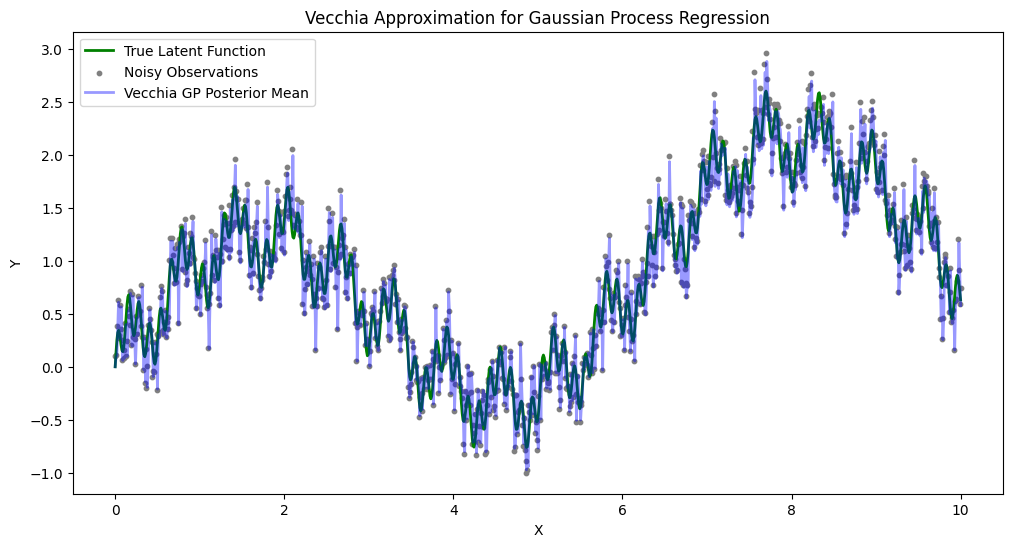

In [42]:
# For visualization, we'll compute the posterior mean using the Vecchia approximation
def compute_vecchia_posterior(Y, X, conditioning_sets, sigma2, rho, jitter=1e-6):
    """
    Compute the posterior mean of the GP using the Vecchia approximation.

    Parameters:
    - Y: Observed data (n,)
    - X: Input locations (n, d)
    - conditioning_sets: List of lists containing indices of conditioning points for each data point
    - sigma2: Variance parameter
    - rho: Range parameter
    - jitter: Small value to add to diagonal for numerical stability

    Returns:
    - posterior_mean: Array of posterior means (n,)
    """
    n = len(Y)
    posterior_mean = np.zeros(n)

    # Precompute the covariance matrix diagonal
    var_y = sigma2 + jitter

    for i in range(n):
        if i == 0 or len(conditioning_sets[i]) == 0:
            # Prior mean is zero
            posterior_mean[i] = 0.0
        else:
            Ci = conditioning_sets[i]
            X_Ci = X[Ci]
            Y_Ci = Y[Ci]

            # Compute covariance matrices
            K_CiCi = exponential_covariance(X_Ci, X_Ci, sigma2, rho) + np.eye(len(Ci)) * jitter
            K_iCi = exponential_covariance(X[i].reshape(1, -1), X_Ci, sigma2, rho)  # Shape: (1, |Ci|)

            # Cholesky decomposition for numerical stability
            try:
                L = cholesky(K_CiCi, lower=True)
            except np.linalg.LinAlgError:
                # Add more jitter if decomposition fails
                K_CiCi += np.eye(len(Ci)) * jitter
                L = cholesky(K_CiCi, lower=True)

            # Solve for alpha: K_CiCi * alpha = Y_Ci
            alpha = solve_triangular(L, Y_Ci, lower=True)
            alpha = solve_triangular(L.T, alpha, lower=False)

            # Conditional mean
            mean_i = K_iCi @ alpha
            posterior_mean[i] = mean_i[0]

    return posterior_mean

# Compute posterior mean
posterior_mean_vecchia = compute_vecchia_posterior(Y, X, conditioning_sets, sigma2, rho)

# Plotting
plt.figure(figsize=(12, 6))
plt.plot(X, true_function, label='True Latent Function', color='green', linewidth=2, alpha = 1)
plt.scatter(X, Y, color='grey', alpha=1, label='Noisy Observations', s=10)
plt.plot(X, posterior_mean_vecchia, label='Vecchia GP Posterior Mean', color='blue', linewidth=2, alpha = 0.4)
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Vecchia Approximation for Gaussian Process Regression')
plt.legend()
plt.show()


can interpolate finer structures better

### NNGP

In [37]:
def select_nngp_neighbors(X, m):
    """
    Select m nearest neighbors among preceding points for each data point to form conditioning sets.
    
    Parameters:
    - X: Input locations (n, d)
    - m: Number of nearest neighbors
    
    Returns:
    - nearest_neighbors: List of lists containing indices of nearest neighbors for each data point
    """
    n = X.shape[0]
    nearest_neighbors = []
    
    for i in range(n):
        if i == 0:
            nearest_neighbors.append([])
            continue
        # Consider only points before the current index
        X_subset = X[:i]
        if X_subset.shape[0] == 0:
            nearest_neighbors.append([])
            continue
        # Fit NearestNeighbors on the subset
        nbrs_subset = NearestNeighbors(n_neighbors=min(m, i), algorithm='auto').fit(X_subset)
        distances, indices = nbrs_subset.kneighbors(X[i].reshape(1, -1), return_distance=True)
        neighbors = indices[0]
        nearest_neighbors.append(neighbors.tolist())
    
    return nearest_neighbors

# Select nearest neighbors for NNGP
nearest_neighbors = select_nngp_neighbors(X, m)


In [38]:
# Compute the optimized NNGP log-likelihood using Vecchia's function
approx_loglik_nngp = compute_vecchia_loglik(Y, X, nearest_neighbors, sigma2, rho)
print(f"NNGP Approximate Log-Likelihood: {approx_loglik_nngp:.7f}")


NNGP Approximate Log-Likelihood: -164.7590774


In [39]:
def negative_nngp_loglik(params, Y, X, nearest_neighbors):
    """
    Negative Vecchia log-likelihood for NNGP optimization.
    
    Parameters:
    - params: Tuple containing (sigma2, rho)
    - Y: Observed data (n,)
    - X: Input locations (n, d)
    - nearest_neighbors: Conditioning sets for NNGP
    
    Returns:
    - Negative log-likelihood
    """
    sigma2, rho = params
    # Ensure parameters are positive
    if sigma2 <= 0 or rho <= 0:
        return np.inf
    loglik = compute_vecchia_loglik(Y, X, nearest_neighbors, sigma2, rho)
    return -loglik  # Negative for minimization

# Optimize hyperparameters for NNGP
result_nngp = minimize(
    negative_nngp_loglik,
    initial_params,
    args=(Y, X, nearest_neighbors),
    bounds=bounds,
    method='L-BFGS-B',
    options={'disp': True}
)

optimized_sigma2_nngp, optimized_rho_nngp = result_nngp.x
print(f"Optimized sigma^2 (NNGP): {optimized_sigma2_nngp:.3f}")
print(f"Optimized rho (NNGP): {optimized_rho_nngp:.3f}")

# Update hyperparameters with optimized values
sigma2_nngp = optimized_sigma2_nngp  # Variance parameter
rho_nngp = optimized_rho_nngp        # Range parameter

# Compute the optimized NNGP log-likelihood
approx_loglik_nngp = compute_vecchia_loglik(Y, X, nearest_neighbors, sigma2_nngp, rho_nngp)
print(f"NNGP Approximate Log-Likelihood: {approx_loglik_nngp:.7f}")


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.36527D+02    |proj g|=  5.34836D+02

At iterate    1    f=  1.65633D+02    |proj g|=  8.24462D+00

At iterate    2    f=  1.65372D+02    |proj g|=  3.87023D+00

At iterate    3    f=  1.65247D+02    |proj g|=  1.81014D+00

At iterate    4    f=  1.65108D+02    |proj g|=  5.47445D-01

At iterate    5    f=  1.64889D+02    |proj g|=  3.00483D+00

At iterate    6    f=  1.64779D+02    |proj g|=  2.97700D+00

At iterate    7    f=  1.64760D+02    |proj g|=  1.60632D+00

At iterate    8    f=  1.64759D+02    |proj g|=  7.55421D-02

At iterate    9    f=  1.64759D+02    |proj g|=  4.00547D-02
Optimized sigma^2 (NNGP): 1.484
Optimized rho (NNGP): 0.356

At iterate   10    f=  1.64759D+02    |proj g|=  3.76303D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function eval

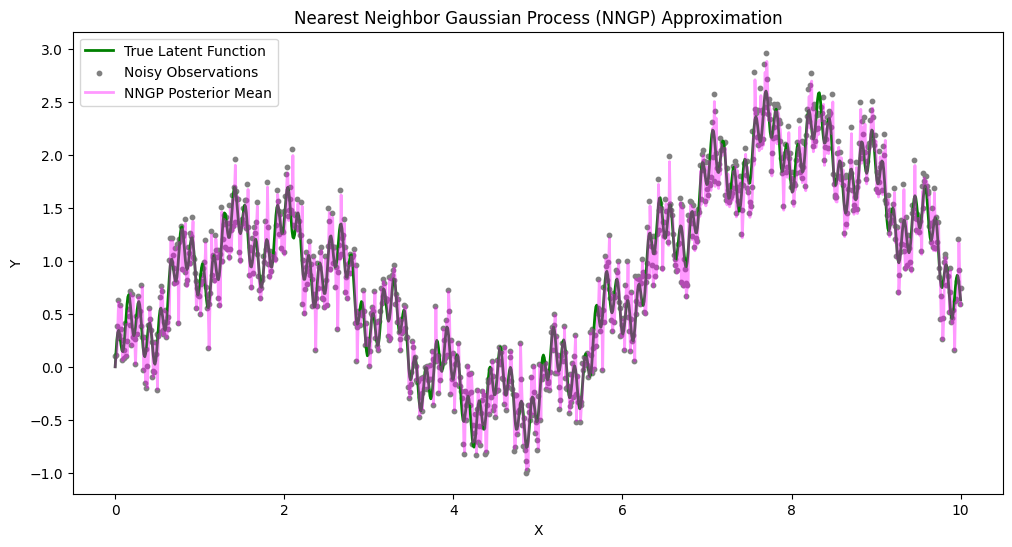

In [64]:
# Compute posterior mean using Vecchia's function for NNGP
posterior_mean_nngp = compute_vecchia_posterior(Y, X, nearest_neighbors, sigma2_nngp, rho_nngp)

# Plotting NNGP Results
plt.figure(figsize=(12, 6))
plt.plot(X, true_function, label='True Latent Function', color='green', linewidth=2, alpha=1)
plt.scatter(X, Y, color='grey', alpha=1, label='Noisy Observations', s=10)
plt.plot(X, posterior_mean_nngp, label='NNGP Posterior Mean', color='fuchsia', linewidth=2, alpha=0.4)
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Nearest Neighbor Gaussian Process (NNGP) Approximation')
plt.legend()
plt.show()


In [41]:
# Compute exact log-likelihood only if n is manageable
if n <= 1000:
    exact_loglik = compute_exact_loglik(Y, X, sigma2_nngp, rho_nngp)
    print(f"Exact Log-Likelihood: {exact_loglik:.7f}")
    print(f"Absolute Difference: {abs(approx_loglik_nngp - exact_loglik):.7f}")


Exact Log-Likelihood: -164.7590713
Absolute Difference: 0.0000061


In [48]:
(posterior_mean_nngp - posterior_mean_vecchia)[0:10]

array([ 0.00000000e+00, -6.20784037e-08, -6.86191797e-08, -2.37840692e-07,
       -3.92047790e-07, -1.86115272e-07, -1.71194531e-07, -3.63707356e-07,
       -2.22851217e-07, -3.84983997e-08])

the means are nearly identical.